# Tutorial/Walkthrough of the multi_plot class and what you can do with it

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import yt
import trident
from IPython.display import Image
from multi_plot import multi_plot
from center_finder import find_center

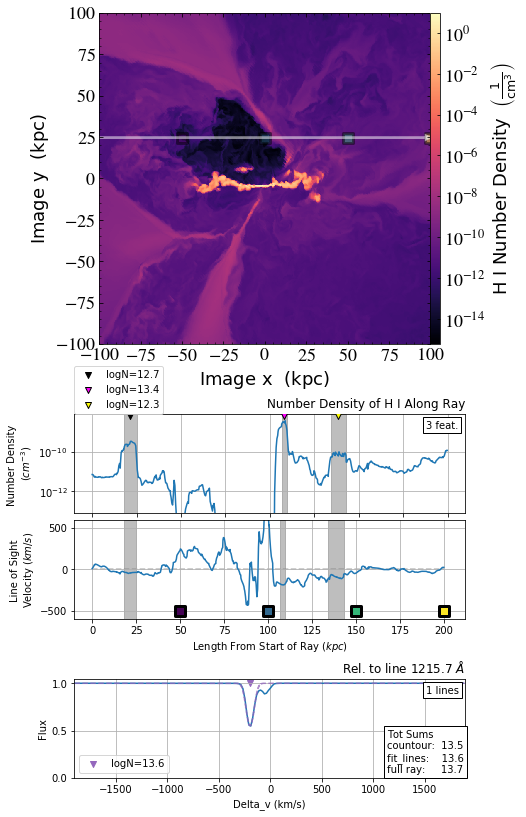

In [18]:
Image('sample_mp.png')

First define parameters and file paths to dataset as well as ray

In [2]:
ds_fname = "/mnt/gs18/scratch/users/boydbre1/"+ \
           "cosmological/foggie/RD0036/RD0036"

ray_fname="/mnt/gs18/scratch/users/boydbre1/" + \
          "multiplot_movie/foggie/RD0036/movie_200kpc/rays/ray188.h5"

#center finder first tries to find the given ds (RD0036 in this case)
#in center_normal_track.dat and use the saved values
#otherwise it calculates them 
center, norm_vec, redshift, bulk_vel = find_center(ds_fname)

Call the `multi_plot` class with the defined parameters

In [3]:
mp = multi_plot(ds_fname, ray_fname, 
                ion_name='H I',        # ion to look at
                north_vector=norm_vec, # vector poiting along galaxy's axis of rotaion
                center_gal=center,     # coordinates of galaxy's center
                wavelength_width=20,   # width of spectra plot in wavelength space
                redshift=redshift,     # redshift of simulation
                use_spectacle=True,    # whether to fit spectra with spectacle
                plot_spectacle=True)   # whether to plot spectacle fits on spectra

yt : [ERROR    ] 2019-08-08 15:19:17,134 Missing omega_radiation in parameter file definition!


<Figure size 720x720 with 0 Axes>

# Computing column densities 
Currently there are three methods used by the `multi_plot` class:

* Contour method `mp.contour`
* Fitting method `mp.use_spectacle`
* Full Sum method

The Contour method uses code constructed by Hillary Egan and can be found on bitbucket or maybe I'll add it to this Repo. The method works by using an initial cutoff (which is roughly the mean background density for the given ion) to define regions in numberdensity where there is at least one absorber. Then for a given region, it finds the maximum number density and sets the cutoff to be a fraction of that (currently 0.5). Then intervals are defined as continuous regions where the number density is above this new cutoff. Then intervals are discared if their column density is too small (default is LogN>12.0 see `spectacle_defaults` for altering this).  

The Fitting method extracts absorbers by trying to fit the absorption spectra created by trident machinery. The fitting is done by using the spectacle libray and the type of features it attempts to fit to the spectra can be altered by setting the `spectacle_defaults`. Some defaults parameters are automatically set when initializing the class. 

The last method is the simplest method. It simply sums the total column density of the light ray and returns that value. It doesn't attempt to extract any individual features or any other paramet

### How to get Absorption information

If all you want is the column densities then you can use `mp.compute_col_density` and take the first object returned which will have a list of column densities computed using the contour method, fitting method, and then the full sum.

In [12]:
col_densities, txt, lines, n_fitted = mp.compute_col_density() 
contour_cd, fitted_cd, full_sum_cd = col_densities

#print out values
print("Total Column Density (LogN with N in cm^-2)")
print(f"Contour method: {contour_cd:.2f}")
print(f"Fitted method: {fitted_cd:.2f}")
print(f"Full Sum method: {full_sum_cd:.2f}")

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 563/563 [00:00<00:00, 2664.44it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -208.74 km / s (1215.67 Angstrom)
    Column density: 13.2486, (1.77256e+13 1 / cm2)
    Doppler width: 42.731 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -56.9147 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s


Total Column Density (LogN with N in cm^-2)
Contour method: 13.51
Fitted method: 13.59
Full Sum method: 13.72


the `multi_plot` class can give more than just the total column densities. For the first two methods, each absorption feature can be returned using `mp.compute_col_density` and `mp.get_contour_intervals`

Once you have the intervals from `mp.get_contour_intervals` you can use them to access any of the fields in the ray (which can be accessed through `mp.ray`). In this example we get the velocity of the absorption feature as well as it's column density

In [13]:
#for the contour method
intervals, cont_lcd = mp.get_contour_intervals()

print(f"The contour method found {len(cont_lcd)} features:")
for inter, lcd in zip(intervals, cont_lcd):
    #get the beginning and ending index of the interval
    b, e = inter
    
    #find average velocity of feature (along ray)
    velocity_los = mp.ray.data['velocity_los'].in_units('km/s')
    avg_vel = np.mean( velocity_los[b:e] )
    
    print(f"LogN={lcd:.2f} with a velocity of {avg_vel:.0f} km/s")
    

The contour method found 3 features:
LogN=12.72 with a velocity of -42 km/s km/s
LogN=13.40 with a velocity of -184 km/s km/s
LogN=12.28 with a velocity of -95 km/s km/s


`mp.compute_col_density()` outputs the spectacle's Spectral1D class for the largest absorbers found using the fitting method (it is the third output). This holds all the information about the 

In [16]:
#for the fitting method
col_densities, txt, largest_lines, n_fitted = mp.compute_col_density() 

#the txt is meant to be written to a text box when creating the full multi-plot

#largest lines hold spectacle models for the largest absorbers (max of 3)
print(f"The Fitting method found {n_fitted} lines/features")

for line_mod in largest_lines:
    lcd = line_mod.lines[0].column_density.value
    delta_vel = line_mod.lines[0].delta_v.value
    print(f"LogN={lcd:.2f} with a velocity of {delta_vel:.0f} km/s")

Adding line - H I 1216 [1215.670100 A]: : 100%|██████████| 563/563 [00:00<00:00, 2588.12it/s]
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -208.74 km / s (1215.67 Angstrom)
    Column density: 13.2486, (1.77256e+13 1 / cm2)
    Doppler width: 42.731 km / s
spectacle [INFO    ]: Estimated initial values:
    Ion: HI1216
    Centroid: -56.9147 km / s (1215.67 Angstrom)
    Column density: -inf, (0 1 / cm2)
    Doppler width: 0 km / s
spectacle [WARNING ]: AstropyDeprecationWarning: The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.


The Fitting method found 1 lines/features
LogN=13.59 with a velocity of -194 km/s


## Creating a slice

multi plot will automatically create a slice of ion's number density with the right orientation based on the given `north_vector` and the given ray. Creating the slice can take a couple minutes if the simulation is large or has very high resolution.

The slice is created such that it is in the plane of the ray and so that the "up"/Z direction is pointing in the same direction as the galaxy's axis of rotation (perpendicular to the disk).

The ray is annotated on the slice so you can see what physical features are being hit by the ray. Markers are also plotted if `mp.markers` is set to True (defaulted to true when class is initialized). These markers are there to make it easy to look from the slice to the number density and line of site velocity plots

yt : [WARNING  ] 2019-08-08 15:58:34,238 Field ('gas', 'H_p0_ion_fraction') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,239 Field ('gas', 'H_ion_fraction') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,240 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,240 Field ('gas', 'H_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,241 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,242 Field ('gas', 'H_density') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,243 Field ('gas', 'H_p0_mass') already exists. Not clobbering.
yt : [WARNING  ] 2019-08-08 15:58:34,243 Field ('gas', 'H_mass') already exists. Not clobbering.



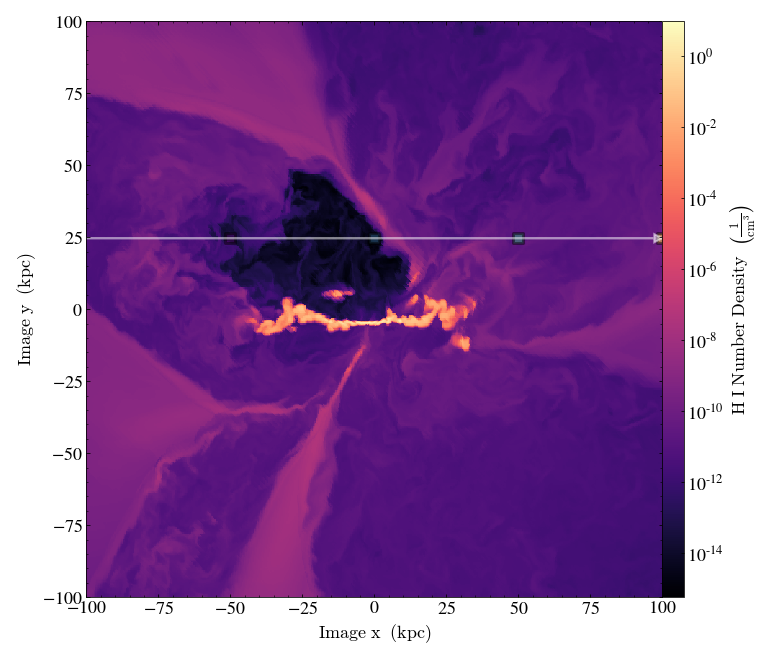

In [17]:
mp.create_slice()

This is then saved and can be interacted with like a regular YT Slice plot


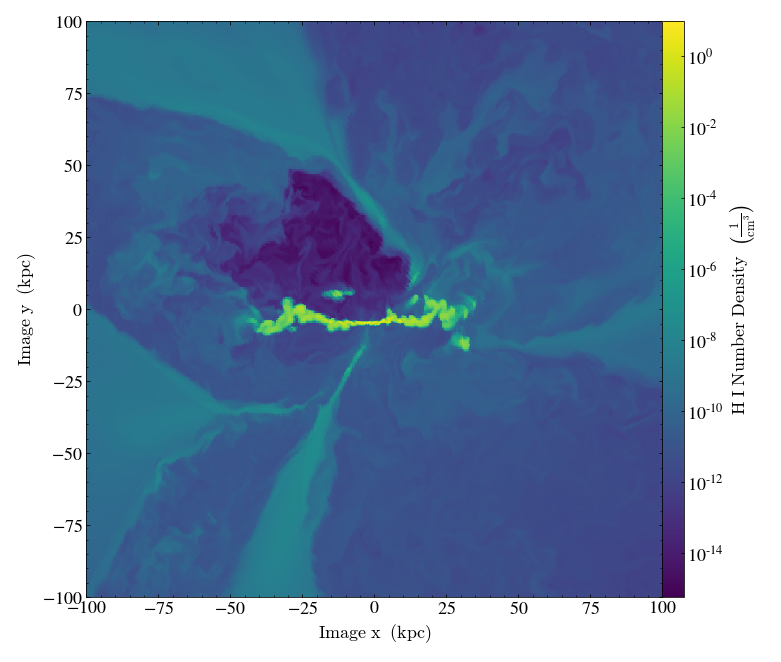

In [19]:
#add a title
mp.slice.annotate_title("A Nice Title")

# change the color map
mp.slice.set_cmap('H_p0_number_density', 'viridis')

# clear all annotations
mp.slice.annotate_clear()

You can re add ray/marker annotaions to the slice by using the mp.add_annotations


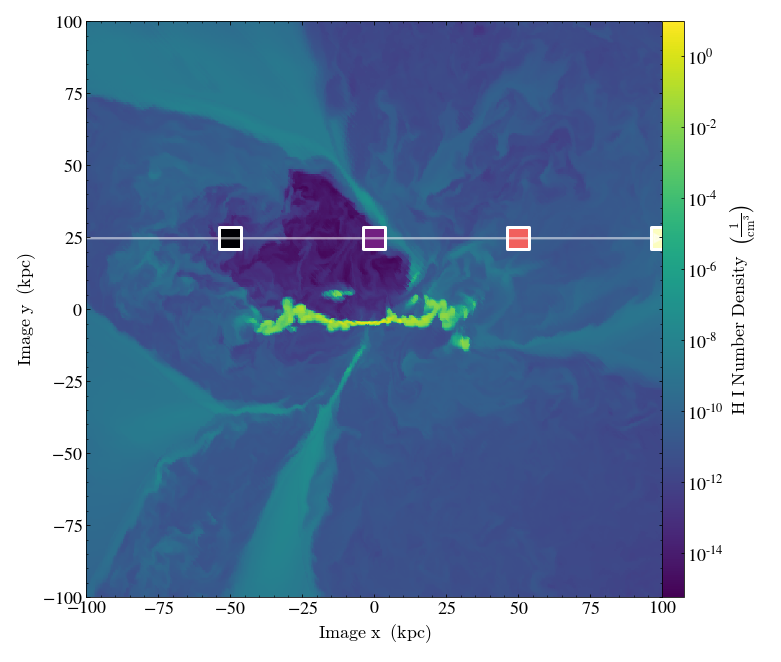

In [20]:
#change some of the marker properties
mp.mark_kwargs
mp.mark_kwargs.update({"s": 500, "edgecolors":'white', "alpha":1})
mp.marker_cmap = "magma"
mp.add_annotations()
mp.slice

In [29]:
# rest markers back to default
mp.mark_kwargs =  {'alpha' : 0.45,
                   's' : 100,
                   'edgecolors' : 'black',
                   'linewidth' : 3}
mp.marker_cmap = 'viridis'
mp.slice.annotate_clear()
mp.add_annotations()

## Number Density and Line of Sight Velocity Plots
How to make plots of number density and line of sight velocity along light ray

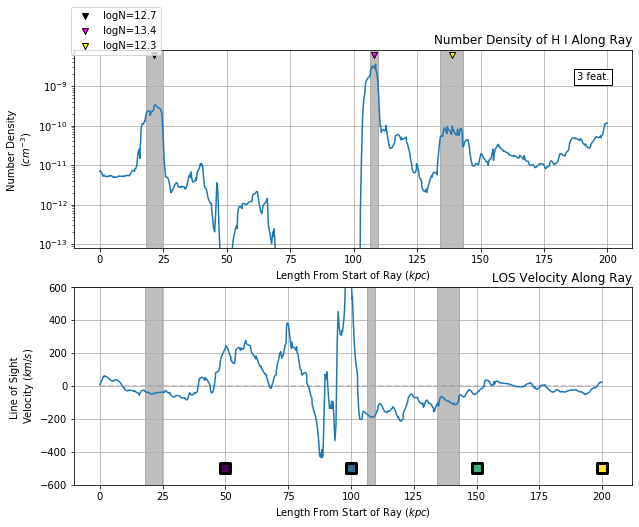

In [30]:
#first create fig and axes

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))

mp.plot_num_dense_los_vel(ax_num_dense=ax1, ax_los_velocity=ax2)

By default the `mp.contour` is set to be True so intervals will be plotted onto the two plots. 